In [ ]:
!unzip /content/drive/MyDrive/majorproject/data-20240317T092757Z-001.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/valid/Mild_Demented/mild_875.jpg  
  inflating: data/valid/Mild_Demented/mild_867.jpg  
  inflating: data/valid/Mild_Demented/mild_385.jpg  
  inflating: data/valid/Mild_Demented/mild_364.jpg  
  inflating: data/valid/Mild_Demented/mild_45.jpg  
  inflating: data/valid/Mild_Demented/mild_835.jpg  
  inflating: data/valid/Mild_Demented/mild_294.jpg  
  inflating: data/valid/Mild_Demented/mild_103.jpg  
  inflating: data/valid/Mild_Demented/mild_23.jpg  
  inflating: data/valid/Mild_Demented/mild_15.jpg  
  inflating: data/valid/Mild_Demented/mild_688.jpg  
  inflating: data/valid/Mild_Demented/mild_524.jpg  
  inflating: data/valid/Mild_Demented/mild_441.jpg  
  inflating: data/valid/Mild_Demented/mild_599.jpg  
  inflating: data/valid/Mild_Demented/mild_504.jpg  
  inflating: data/valid/Mild_Demented/mild_888.jpg  
  inflating: data/valid/Mild_Demented/mild_890.jpg  
  inflating: data/valid/Mild_Demented/mild_676.jpg 

In [ ]:
import os
from collections import Counter
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define the paths to your data folders
train_path = '/content/data/train'
valid_path = '/content/data/valid'
test_path = '/content/data/test'

# Define the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation parameters
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(**data_gen_args, rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train, valid, and test data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Get the class labels and number of classes
class_labels = train_generator.class_indices
num_classes = len(class_labels)

# Print class distribution in the train, valid, and test sets
print("Train set class distribution:", Counter(train_generator.classes))
print("Valid set class distribution:", Counter(valid_generator.classes))
print("Test set class distribution:", Counter(test_generator.classes))

Found 3839 images belonging to 4 classes.
Found 2242 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Train set class distribution: Counter({2: 1920, 3: 1344, 0: 537, 1: 38})
Valid set class distribution: Counter({2: 1120, 3: 784, 0: 315, 1: 23})
Test set class distribution: Counter({2: 160, 3: 112, 0: 44, 1: 3})


In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense
from keras.models import Model
from keras.regularizers import l2

def resnet_block(inputs, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu', regularizer=l2(0.001)):
    """
    Residual block with shortcut connection.
    """
    shortcut = inputs

    x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_regularizer=regularizer)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=regularizer)(x)
    x = BatchNormalization()(x)

    if strides != (1, 1) or inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_regularizer=regularizer)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = x + shortcut
    x = Activation(activation)(x)

    return x

def resnet(input_shape, num_classes, num_blocks=3, num_filters=64):
    """
    ResNet architecture with user-defined number of blocks and filters.
    """
    inputs = Input(shape=input_shape)

    x = Conv2D(num_filters, (7, 7), strides=(2, 2), padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for i in range(num_blocks):
        num_filters *= 2
        x = resnet_block(x, num_filters, strides=(1 if i == 0 else 2, 1 if i == 0 else 2))

    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)

    return model

# Example usage
input_shape = (224, 224, 3)
num_classes = 4
model = resnet(input_shape, num_classes, num_blocks=4, num_filters=64)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 112, 112, 64)         9472      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_13 (Ba  (None, 112, 112, 64)         256       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_9 (Activation)   (None, 112, 112, 64)         0         ['batch_normalization_13

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import os

# Define the paths to your data folders
train_path = '/content/data/train'
valid_path = '/content/data/valid'
test_path = '/content/data/test'

# Define the hyperparameters
batch_size = 16
epochs =30
learning_rate = 0.01
momentum = 0.9

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train, valid, and test data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

checkpoint = ModelCheckpoint('Alzhiemer_resnetmodel.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint]
)

# Load the best model
model.save('Alzhiemer_resnetmodel.h5')

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

Found 3839 images belonging to 4 classes.
Found 2242 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Epoch 1/30
239/239 [==============================] - ETA: 0s - loss: 5.3201 - accuracy: 0.5540
Epoch 1: val_accuracy improved from -inf to 0.26161, saving model to Alzhiemer_resnetmodel.h5
239/239 [==============================] - 42s 137ms/step - loss: 5.3201 - accuracy: 0.5540 - val_loss: 5.7852 - val_accuracy: 0.2616
Epoch 2/30
239/239 [==============================] - ETA: 0s - loss: 4.6513 - accuracy: 0.7060
Epoch 2: val_accuracy improved from 0.26161 to 0.69152, saving model to Alzhiemer_resnetmodel.h5
239/239 [==============================] - 28s 118ms/step - loss: 4.6513 - accuracy: 0.7060 - val_loss: 4.6261 - val_accuracy: 0.6915
Epoch 3/30
239/239 [==============================] - ETA: 0s - loss: 4.1036 - accuracy: 0.8161
Epoch 3: val_accuracy did not improve from 0.69152
239/239 [==============================] - 27s 112ms/step - loss: 4.1036 - ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-8-ef7438c03ce1>:65: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_generator.samples // batch_size)


Test loss: 1.0881
Test accuracy: 0.8257


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image

# Load the saved model
model = load_model('/content/Alzhiemer_resnetmodel.h5')

# Load the class labels
class_labels = {value: key for key, value in train_generator.class_indices.items()}

# Ask the user to provide the image path
image_path = input("Enter the path to the image: ")

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make the prediction
prediction = model.predict(x)

# Convert the prediction to a class label
predicted_class = class_labels[np.argmax(prediction)]

# Print the predicted label
print(f"Predicted label: {predicted_class}")

Enter the path to the image: /content/data/test/Moderate_Demented/moderate_30.jpg
1/1 [==============================] - 1s 1s/step
Predicted label: Moderate_Demented


Enter the path to the image: /content/data/test/Non_Demented/non_1059.jpg
1/1 [==============================] - 0s 375ms/step


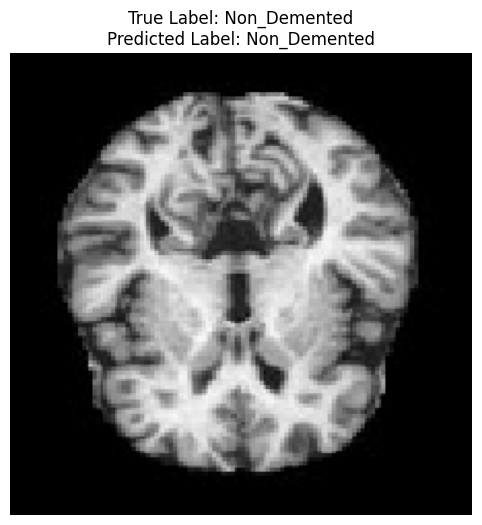

Image path: /content/data/test/Non_Demented/non_1059.jpg
True label: Non_Demented
Predicted label: Non_Demented


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/Alzhiemer_resnetmodel.h5')

# Load the class labels
class_labels = {value: key for key, value in train_generator.class_indices.items()}

# Ask the user to provide the image path
image_path = input("Enter the path to the image: ")

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make the prediction
prediction = model.predict(x)

# Convert the prediction to a class label
predicted_class = class_labels[np.argmax(prediction)]

# Get the true label from the image path
true_label = image_path.split('/')[-2]  # Assuming the true label is the name of the folder containing the image

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Display the image
ax.imshow(img)
ax.axis('off')
ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_class}")

# Show the figure
plt.show()

# Print the image path, true label, and predicted label
print(f"Image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted label: {predicted_class}")

Enter the path to the image: /content/data/test/Moderate_Demented/moderate_30.jpg
1/1 [==============================] - 0s 232ms/step


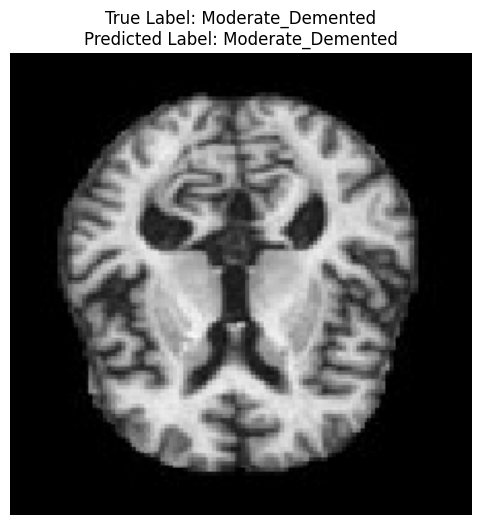

Image path: /content/data/test/Moderate_Demented/moderate_30.jpg
True label: Moderate_Demented
Predicted label: Moderate_Demented


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/Alzhiemer_resnetmodel.h5')

# Load the class labels
class_labels = {value: key for key, value in train_generator.class_indices.items()}

# Ask the user to provide the image path
image_path = input("Enter the path to the image: ")

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make the prediction
prediction = model.predict(x)

# Convert the prediction to a class label
predicted_class = class_labels[np.argmax(prediction)]

# Get the true label from the image path
true_label = image_path.split('/')[-2]  # Assuming the true label is the name of the folder containing the image

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Display the image
ax.imshow(img)
ax.axis('off')
ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_class}")

# Show the figure
plt.show()

# Print the image path, true label, and predicted label
print(f"Image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted label: {predicted_class}")

Enter the path to the image: /content/data/test/Mild_Demented/mild_287.jpg
1/1 [==============================] - 0s 357ms/step


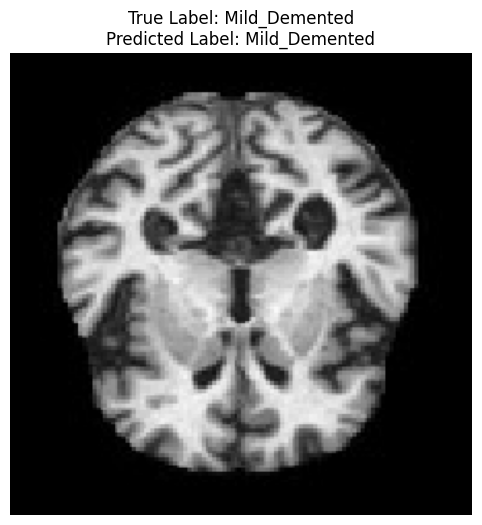

Image path: /content/data/test/Mild_Demented/mild_287.jpg
True label: Mild_Demented
Predicted label: Mild_Demented


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/Alzhiemer_resnetmodel.h5')

# Load the class labels
class_labels = {value: key for key, value in train_generator.class_indices.items()}

# Ask the user to provide the image path
image_path = input("Enter the path to the image: ")

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make the prediction
prediction = model.predict(x)

# Convert the prediction to a class label
predicted_class = class_labels[np.argmax(prediction)]

# Get the true label from the image path
true_label = image_path.split('/')[-2]  # Assuming the true label is the name of the folder containing the image

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Display the image
ax.imshow(img)
ax.axis('off')
ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_class}")

# Show the figure
plt.show()

# Print the image path, true label, and predicted label
print(f"Image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted label: {predicted_class}")

Enter the path to the image: /content/data/test/Very_Mild_Demented/verymild_1174.jpg


1/1 [==============================] - 0s 254ms/step


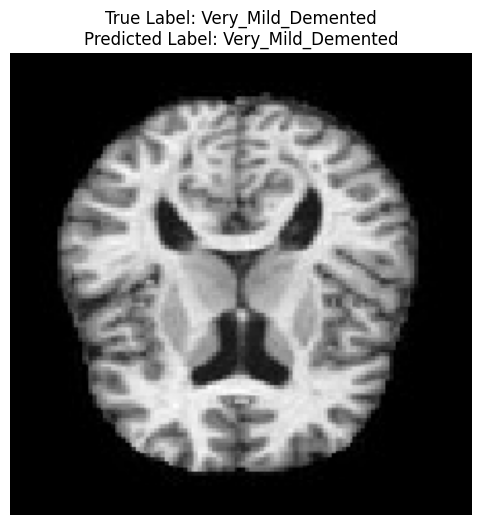

Image path: /content/data/test/Very_Mild_Demented/verymild_1174.jpg
True label: Very_Mild_Demented
Predicted label: Very_Mild_Demented


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/content/Alzhiemer_resnetmodel.h5')

# Load the class labels
class_labels = {value: key for key, value in train_generator.class_indices.items()}

# Ask the user to provide the image path
image_path = input("Enter the path to the image: ")

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make the prediction
prediction = model.predict(x)

# Convert the prediction to a class label
predicted_class = class_labels[np.argmax(prediction)]

# Get the true label from the image path
true_label = image_path.split('/')[-2]  # Assuming the true label is the name of the folder containing the image

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Display the image
ax.imshow(img)
ax.axis('off')
ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_class}")

# Show the figure
plt.show()

# Print the image path, true label, and predicted label
print(f"Image path: {image_path}")
print(f"True label: {true_label}")
print(f"Predicted label: {predicted_class}")